<a href="https://colab.research.google.com/github/JMML2021/Entrega-projecte-final/blob/main/utilitzar_loggistic_regression_per_mirar_els_coeficients_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Activo Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Obrir fitxer creat amb Calculo Vueling 2022 con codigos Rev D.ipynb
#path='/content/drive/MyDrive/2022.06.03 2022_delay + cierre puertas CORTO.xlsx'
Hoja = 'FLT_2022'
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx')
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-10-10 07:25:00.012463 FLT_2022.xlsx')
df = pd.read_excel(path) #, sheet_name=Hoja)


In [4]:
# Para crear una "logistic regresion":
# 10 minuts és el temps que s'accepta com arribar a l'hora

df['Tard1'] = np.where(df['Puntualidad1'] <10, 0, 1)
df['Tard2'] = np.where(df['Puntualidad2'] <10, 0, 1)
df['Tard3'] = np.where(df['Puntualidad3'] <10, 0, 1)

In [6]:
#@title crec el DataFrame df1
df1=df[['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3']]

In [7]:
#@#@title Estandarditzar les característiques eliminant la mitjana i escalant a la variància de la unitat.

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([(df1.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df1.copy(), 4)
df1_StdScaler= pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

df1_StdScaler.head()

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,0.661875,0.158984,-0.020942,1.006091,0.398530,-0.039738,-0.022665,-0.049533,0.000086,2.979681,-0.387587,-0.362741
1,-0.620447,-0.405877,-0.020942,-0.939568,-0.840450,-0.655431,0.018437,0.025896,0.365863,-0.335606,-0.387587,-0.362741
2,0.245987,0.204173,-0.169253,0.340471,0.133034,-0.095710,0.018437,0.151611,-0.132924,-0.335606,-0.387587,-0.362741
3,0.800504,0.000823,-0.525200,1.159696,0.575527,-0.543487,0.018437,-0.326106,-0.265933,2.979681,-0.387587,-0.362741
4,0.176672,-0.134744,-0.050604,-0.222746,-0.530705,-0.263626,0.388352,0.151611,0.099843,-0.335606,-0.387587,-0.362741


In [8]:
#@title Elimino els outliers. df2
df2=df1.copy()

dfEliminarOutliers= ((df2['E_Despegue']> -30) & 
                     (df2['E_Despegue']< 30) & 
                     (df2['Puntualidad1']< 30) & 
                     (df2['Puntualidad1']>-30) &
                     (df2['Puntualidad2']< 30) & 
                     (df2['Puntualidad2']>-30)&
                     (df2['E_Despegue2']< 30) & 
                     (df2['E_Despegue2']>-30)&
                     (df2['Puntualidad3']< 30) & 
                     (df2['Puntualidad3']>-30)&
                     (df2['E_Despegue3']< 30) & 
                     (df2['E_Despegue3']>-30))

df2 = df2[dfEliminarOutliers]

In [14]:
#@title Quantitat de outliers que hi ha
print(df1.shape)
print(df2.shape)
percentatje= round((df2.shape[0]-df1.shape[0])/df1.shape[0]*100/3,2)
print('quantitat de files afectades per outliers per salt= ', percentatje)

(12358, 12)
(10708, 12)
quantitat de files afecatdes=  -4.45


In [15]:
#@title Creo Subrutina de metricas:

#Importo scikit-learn metrics module para el calculo
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
metricasEjercicio2=[]
######################################################################
 
def MetricasModelo(metodo, Y_real, Y_calculado, scores):
  print('Metodo: ', metodo)
  
  #Precisión del modelo: ¿con qué frecuencia es correcto el clasificador?
  #accuracy = metrics.accuracy_score(Y_real, Y_calculado)
  #print("Accuracy:", accuracy)

  rmse = np.sqrt(mean_squared_error(Y_real, Y_calculado,))
  print("RMSE: %f" % (rmse))
  

  R_squared = r2_score(Y_real, Y_calculado,)

  print("R-Squared: ", np.round(R_squared, 2))
 
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  accuracy = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

  # Guardo metricas
  metricasEjercicio2.append([metodo, rmse, R_squared, accuracy])  


  cnf_matrix_SVM = metrics.confusion_matrix(Y_real, Y_calculado)

  print('\n\nMatriz de Confusión')
  print(cnf_matrix_SVM)


  # Creamos la Matriz de Confusion:

  class_names=[0,1] # name  of classes
  
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap

  sns.heatmap(pd.DataFrame(cnf_matrix_SVM), annot=True, cmap="gist_ncar" ,fmt='g')
  ax.xaxis.set_label_position("top")
 

  plt.tight_layout()
  plt.title('Matriu de confusió', y=1.1)
  plt.ylabel('Valor Actual')
  plt.xlabel('Valor predit')
  plt.Text(1.5,257.44,'Predicció')


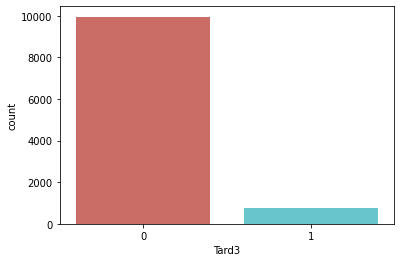

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=df2, palette='hls')
plt.show()

In [30]:
# Creació del model utilitzant matrius com a scikitlearn
# ================================================= =============================
# A la matriu de predictors cal afegir una columna de 1s per a l'intercept del model

import statsmodels.api as sm

# Divisió de les dades en train i test
# ==============================================================================
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.194613
         Iterations: 35
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.228      
Dependent Variable: Tard3            AIC:              3346.1032  
Date:               2022-10-10 23:33 BIC:              3388.4365  
No. Observations:   8566             Log-Likelihood:   -1667.1    
Df Model:           5                LL-Null:          -2158.1    
Df Residuals:       8560             LLR p-value:      4.4908e-210
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
---------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
---------------------------------------------------------------------
x1      0.0870         nan        nan       nan        nan        nan
x2      0.0369      0.0022    17.0495    0.0000     0.0326     0.0411
x3     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [31]:
#@title Dades standarizatdes:

#@title Estandarditzar les característiques eliminant la mitjana i escalant a la variància de la unitat.

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler


mapper = DataFrameMapper([(df2.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df2.copy(), 4)
df2_StdScaler= pd.DataFrame(scaled_features, index=df2.index, columns=df2.columns)

df2_StdScaler.head()

datos_x= df2_StdScaler.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.640394
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: -1.542    
Dependent Variable: Tard3            AIC:              10983.2350
Date:               2022-10-10 23:33 BIC:              11025.5683
No. Observations:   8566             Log-Likelihood:   -5485.6   
Df Model:           5                LL-Null:          -2158.1   
Df Residuals:       8560             LLR p-value:      1.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
    Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
-----------------------------------------------------------------
x1 -0.0017 1712852.5986 -0.0000 1.0000 -3357129.4057 3357129.4024
x2 -0.0040          nan     nan    nan           nan          nan
x3 -0.0060 1178154.9933 -0.0000 1.00

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [32]:
# Creació del model utilitzant matrius com a scikitlearn
# ================================================= =============================
# A la matriu de predictors cal afegir una columna de 1s per a l'intercept del model

import statsmodels.api as sm

# Divisió de les dades en train i test
# ==============================================================================
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.194613
         Iterations: 35
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.228      
Dependent Variable: Tard3            AIC:              3346.1032  
Date:               2022-10-10 23:33 BIC:              3388.4365  
No. Observations:   8566             Log-Likelihood:   -1667.1    
Df Model:           5                LL-Null:          -2158.1    
Df Residuals:       8560             LLR p-value:      4.4908e-210
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
---------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
---------------------------------------------------------------------
x1      0.0870         nan        nan       nan        nan        nan
x2      0.0369      0.0022    17.0495    0.0000     0.0326     0.0411
x3     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
